## DICA: VISUALIZAR TODAS AS DISTRUIÇÕES COMO EVENTOS DE POISSION

## DICA:
#### DIVIDIR ANÁLISE EM 4 CATEGORIAS EXPONENCIALS/POISSION:
- DURAÇÃO CADA GRUPO DE MENSAGENS DE UM USUÁRIO
- TEMPO ENTRE GRUPOS DE MENSAGENS DE UM USUÁRIO
- DURAÇÃO CADA CONVERSA DIÁRIA (clusters diarios)
- TEMPO ENTRE CONVERSAS DIÁRIAS (clusters diarios)
- TEMPO INÍCIO CONVERSA DIÁRIA A PARTIR DE MEIA NOITE (clusters diarios)
- TEMPO FIM CONVERSA DIÁRIA A PARTIR DE MEIA NOITE (clusters diarios)
- TEMPO ENTRE CONVERSAS (clusters de conversas)
- DURAÇÃO CADA CONVERSA (clusters de conversas)

#### Para cada uma:
- Modelar exponencial, poisson e projeção

#### Load data

In [400]:
import pandas as pd
import numpy as np

df = pd.read_csv('chat.csv')
df['text'] = np.nan

display(df.head())

,timestamp,user,text,date,time
0,2023-08-09 16:57:00,NaN,NaN,2023-08-09,16:57:00
1,2023-07-19 14:34:00,Luis,NaN,2023-07-19,14:34:00
2,2023-07-19 14:26:00,hanna,NaN,2023-07-19,14:26:00
3,2023-07-19 14:46:00,Luis,NaN,2023-07-19,14:46:00
4,2023-07-19 14:46:00,Luis,NaN,2023-07-19,14:46:00


#### Clean data

In [401]:
# Drop missing values for user
df = df.dropna(subset=['user'])

# Convert timestamps to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Display timestamps
display(df['timestamp'])

1       2023-07-19 14:34:00
2       2023-07-19 14:26:00
3       2023-07-19 14:46:00
4       2023-07-19 14:46:00
5       2023-07-19 14:46:00
                ...        
52454   2024-05-08 18:02:00
52455   2024-05-08 18:03:00
52456   2024-05-08 18:03:00
52457   2024-05-08 18:03:00
52458   2024-05-08 18:20:00
Name: timestamp, Length: 51997, dtype: datetime64[ns]

In [402]:
df['user'] = (df['user'] == 'hanna').astype(int)

display(df.head())


,timestamp,user,text,date,time
1,2023-07-19 14:34:00,0,NaN,2023-07-19,14:34:00
2,2023-07-19 14:26:00,1,NaN,2023-07-19,14:26:00
3,2023-07-19 14:46:00,0,NaN,2023-07-19,14:46:00
4,2023-07-19 14:46:00,0,NaN,2023-07-19,14:46:00
5,2023-07-19 14:46:00,0,NaN,2023-07-19,14:46:00


---
# Feature Engineering

## Time to reply

In [322]:
prev_row = df.iloc[0]

data = []
for idx, row in df.iterrows():    
    user = row['user']
    timestamp = row['timestamp']

    prev_user = prev_row['user']
    prev_timestamp = prev_row['timestamp']

    if user != prev_user:
        timedelta = timestamp - prev_timestamp
        new_row = {
            'index': idx,
            'user': user,
            'timestamp': timestamp,
            'prev_user': prev_user,
            'prev_timestamp': prev_timestamp,
            'timedelta': timedelta,
            'seconds': timedelta.seconds,
            'minutes': timedelta.seconds / 60,
        }
        data.append(new_row)
    prev_row = row
    
reply = pd.DataFrame(data)
reply = reply.iloc[1:].reset_index(drop=True) # Drop first row

reply.head(5)

,index,user,timestamp,prev_user,prev_timestamp,timedelta,seconds,minutes
0,3,Luis,2023-07-19 14:46:00,hanna,2023-07-19 14:26:00,0 days 00:20:00,1200,20.0
1,6,hanna,2023-07-19 14:47:00,Luis,2023-07-19 14:46:00,0 days 00:01:00,60,1.0
2,7,Luis,2023-07-19 14:48:00,hanna,2023-07-19 14:47:00,0 days 00:01:00,60,1.0
3,8,hanna,2023-07-19 14:51:00,Luis,2023-07-19 14:48:00,0 days 00:03:00,180,3.0
4,9,Luis,2023-07-19 14:53:00,hanna,2023-07-19 14:51:00,0 days 00:02:00,120,2.0


## Time between first and last messages of a reply

In [323]:
prev_row = df.iloc[0]

data = []
reply_msgs = []
for idx, row in df.iterrows():    
    user = row['user']
    timestamp = row['timestamp']

    prev_user = prev_row['user']
    prev_timestamp = prev_row['timestamp']

    if user != prev_user:
        timestamp_start = reply_msgs[0]['timestamp']
        timestamp_end = reply_msgs[-1]['timestamp']
        timedelta = timestamp_end - timestamp_start
        new_row = {
            'index': idx,
            'user': prev_user,
            'prev_user': user,
            'messages': len(reply_msgs),
            'start': timestamp_start,
            'end': timestamp_end,
            'timedelta': timedelta,
            'seconds': timedelta.seconds,
            'minutes': timedelta.seconds / 60,
        }
        data.append(new_row)
        reply_msgs = []
        
    reply_msgs.append(row.to_dict())
    prev_row = row
    
replying = pd.DataFrame(data)
# replying = replying.iloc[1:].reset_index(drop=True) # Drop first row

replying.head(5)

,index,user,prev_user,messages,start,end,timedelta,seconds,minutes
0,2,Luis,hanna,1,2023-07-19 14:34:00,2023-07-19 14:34:00,0 days,0,0.0
1,3,hanna,Luis,1,2023-07-19 14:26:00,2023-07-19 14:26:00,0 days,0,0.0
2,6,Luis,hanna,3,2023-07-19 14:46:00,2023-07-19 14:46:00,0 days,0,0.0
3,7,hanna,Luis,1,2023-07-19 14:47:00,2023-07-19 14:47:00,0 days,0,0.0
4,8,Luis,hanna,1,2023-07-19 14:48:00,2023-07-19 14:48:00,0 days,0,0.0


## Time between blobs of messages

#### Parse time between messages in seconds (min-max normalized)

In [324]:
timestamp_delta = df['timestamp'].max() - df['timestamp'].min()

timestamp_delta

Timedelta('294 days 03:54:00')

In [326]:
def as_datetime(delta_norm):
    return df['timestamp'].min() + timestamp_delta * delta_norm

# Exaple usage
# as_datetime(df['uuid'].iloc[0])

In [327]:
(df['timestamp'].max() - df['timestamp'].min()).value / 1e9 / 60 / 60 / 24

294.16249999999997

In [328]:
df['uuid'] = df['timestamp'].apply(lambda d: d.value)
df['uuid'] = (df['uuid'] - df['uuid'].min()) / (df['uuid'].max() - df['uuid'].min()) # Min-Max Scaling

df['uuid']

1        0.000019
2        0.000000
3        0.000047
4        0.000047
5        0.000047
           ...   
52454    0.999958
52455    0.999960
52456    0.999960
52457    0.999960
52458    1.000000
Name: uuid, Length: 51997, dtype: float64

#### Build chat talks from cluster labels

In [329]:
meanshift_df = pd.read_csv('meanshift_pred_0-0000727281.csv', index_col=0)

df['label'] = meanshift_df['label'].loc[df.index]

prev_row = df.iloc[0]

data = []
talk_msgs = []
timestamp_end = None
timedelta_inter = None
for idx, row in df.iterrows():
    label = row['label']
    user = row['user']
    timestamp = row['timestamp']

    prev_label = prev_row['label']
    prev_user = prev_row['user']
    prev_timestamp = prev_row['timestamp']

    if label != prev_label:
        timestamp_start = talk_msgs[0]['timestamp']
        if timestamp_end is not None:
            timedelta_inter = timestamp_start - timestamp_end
        timestamp_end = talk_msgs[-1]['timestamp']
 
        timedelta = timestamp_end - timestamp_start
        new_row = {
            'index': idx,
            'label': prev_label,
            'user': prev_user,
            'prev_user': user,
            'messages': len(talk_msgs),
            'start': timestamp_start,
            'end': timestamp_end,
            'timedelta': timedelta,
            'timedelta_inter': timedelta_inter,
            'seconds': timedelta.seconds,
            'minutes': timedelta.seconds / 60,
            'seconds_inter': None,
            'minutes_inter': None,
        }
        if timedelta_inter is not None:
            new_row = {**new_row, **{
                'seconds_inter': timedelta_inter.seconds,
                'minutes_inter': timedelta_inter.seconds / 60,
            }}
        data.append(new_row)
        talk_msgs = []
        
    talk_msgs.append(row.to_dict())
    prev_row = row
    
talks = pd.DataFrame(data)
talks = talks.iloc[1:].reset_index(drop=True)

print('Number of clusters:', len(talks))
talks.head(5)

Number of clusters: 2826


,index,label,user,prev_user,messages,start,end,timedelta,timedelta_inter,seconds,minutes,seconds_inter,minutes_inter
0,41,982,Luis,hanna,14,2023-07-19 19:30:00,2023-07-19 19:49:00,0 days 00:19:00,0 days 03:34:00,1140,19.0,12840.0,214.0
1,74,527,hanna,Luis,33,2023-07-19 20:16:00,2023-07-19 20:49:00,0 days 00:33:00,0 days 00:27:00,1980,33.0,1620.0,27.0
2,83,1472,hanna,hanna,9,2023-07-19 21:47:00,2023-07-19 22:06:00,0 days 00:19:00,0 days 00:58:00,1140,19.0,3480.0,58.0
3,86,1981,hanna,Luis,3,2023-07-19 22:43:00,2023-07-19 22:44:00,0 days 00:01:00,0 days 00:37:00,60,1.0,2220.0,37.0
4,87,1556,Luis,hanna,1,2023-07-20 09:00:00,2023-07-20 09:00:00,0 days 00:00:00,0 days 10:16:00,0,0.0,36960.0,616.0


---
# Define functions

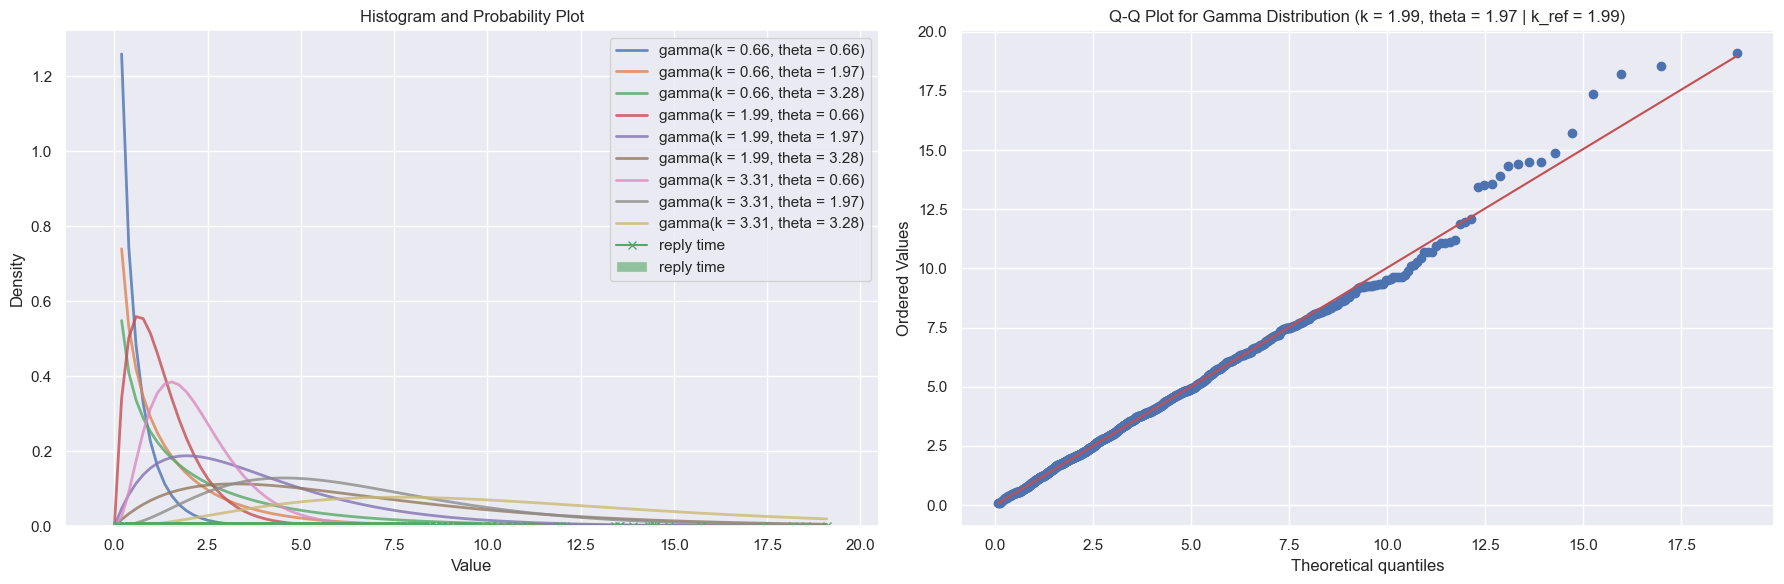

In [341]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# COMPARE VALUES AGAINST EXPONENTIAL DISTRIBUTION
def exponential_comparison_plot(values, lambda_values='auto', n_lambda_values=5, lambda_values_range_prct=0.666, lambda_ref='auto', histogram='counts'):

    lambda_param = 1 / np.mean(values)
    if lambda_values == 'auto':
        interval = lambda_param * lambda_values_range_prct
        lambda_values = np.linspace(lambda_param - interval, lambda_param + interval, n_lambda_values)

    if lambda_ref == 'auto':
       lambda_ref = lambda_param 

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)

    for lambda_ in lambda_values:
        # Theoretical probability density function
        x = np.linspace(0, np.max(values), 100)
        pdf = lambda_ * np.exp(-lambda_ * x)
        plt.plot(x, pdf, linewidth=2, alpha=0.8, label=f'exp(1 / lambda = {round(1 / lambda_, 2)} min)')

    if histogram == 'bins':
        # Histogram
        res = plt.hist(values, bins=30, density=True, alpha=0.6, color='g')
        cnts = res[0]
        bins = res[1][1:] - (res[1][1] - res[1][0]) / 2
        plt.plot(bins, cnts, marker='x', alpha=1.0, color='g', label=f'reply time (after {y_min} min)')

    elif histogram == 'counts':
        X = pd.Series(values).value_counts(normalize=True).sort_index()
        y = X.values
        x = X.index
        plt.bar(x, y, alpha=0.6, color='g', label=f'reply time (after {y_min} min)')
        plt.plot(x, y, marker='x', alpha=1.0, color='g', label=f'reply time (after {y_min} min)')
        
    # Titles and labels
    plt.title('Histogram and Probability Plot')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    
    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(values, dist="expon", sparams=(0, 1 / lambda_ref), plot=plt)
    plt.title(f"Q-Q Plot for Exponential Distribution (lambda = {round(1 / lambda_param, 2)} / min | lambda_ref = {round(1 / lambda_ref, 2)} / min)")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()
# import scipy.stats as stats
# import pandas as pd

# # COMPARE VALUES AGAINST GAMMA DISTRIBUTION
# def gamma_comparison_plot(values, k_values='auto', n_k_values=5, k_values_range_prct=0.666, k_ref='auto', histogram='counts'):

#     k_param = np.mean(values)**2 / np.var(values)
#     theta_param = np.var(values) / np.mean(values)

#     if k_values == 'auto':
#         interval = k_param * k_values_range_prct
#         k_values = np.linspace(k_param - interval, k_param + interval, n_k_values)

#     if k_ref == 'auto':
#         k_ref = k_param 

#     plt.figure(figsize=(18, 6))
#     plt.subplot(1, 2, 1)

#     for k_ in k_values:
#         # Theoretical probability density function
#         x = np.linspace(0, np.max(values), 100)
#         pdf = stats.gamma.pdf(x, k_, scale=theta_param)
#         plt.plot(x, pdf, linewidth=2, alpha=0.8, label=f'gamma(k = {round(k_, 2)}, theta = {round(theta_param, 2)})')

#     if histogram == 'bins':
#         # Histogram
#         res = plt.hist(values, bins=30, density=True, alpha=0.6, color='g')
#         cnts = res[0]
#         bins = res[1][1:] - (res[1][1] - res[1][0]) / 2
#         plt.plot(bins, cnts, marker='x', alpha=1.0, color='g', label='reply time')

#     elif histogram == 'counts':
#         X = pd.Series(values).value_counts(normalize=True).sort_index()
#         y = X.values
#         x = X.index
#         plt.bar(x, y, alpha=0.6, color='g', label='reply time')
#         plt.plot(x, y, marker='x', alpha=1.0, color='g', label='reply time')
        
#     # Titles and labels
#     plt.title('Histogram and Probability Plot')
#     plt.xlabel('Value')
#     plt.ylabel('Density')
#     plt.legend()
    
#     # Q-Q Plot
#     plt.subplot(1, 2, 2)
#     stats.probplot(values, dist="gamma", sparams=(k_ref, 0, theta_param), plot=plt)
#     plt.title(f"Q-Q Plot for Gamma Distribution (k = {round(k_param, 2)}, theta = {round(theta_param, 2)} | k_ref = {round(k_ref, 2)})")
    
#     # Show the plot
#     plt.tight_layout()
#     plt.show()

# # Example usage with sample data
# data = np.random.gamma(shape=2, scale=2, size=1000)
# gamma_comparison_plot(data)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats
import pandas as pd

# COMPARE VALUES AGAINST GAMMA DISTRIBUTION
def gamma_comparison_plot(values, k_values='auto', n_k_values=3, k_values_range_prct=0.666, k_ref='auto', histogram='counts'):

    k_param = np.mean(values)**2 / np.var(values)
    theta_param = np.var(values) / np.mean(values)

    if k_values == 'auto':
        interval = k_param * k_values_range_prct
        k_values = np.linspace(k_param - interval, k_param + interval, n_k_values)
    
    theta_values = theta_param + np.linspace(-interval, interval, n_k_values) * theta_param / k_param

    if k_ref == 'auto':
        k_ref = k_param 

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)

    for k_ in k_values:
        for theta_ in theta_values:
            # Theoretical probability density function
            x = np.linspace(0, np.max(values), 100)
            pdf = stats.gamma.pdf(x, k_, scale=theta_)
            plt.plot(x, pdf, linewidth=2, alpha=0.8, label=f'gamma(k = {round(k_, 2)}, theta = {round(theta_, 2)})')

    if histogram == 'bins':
        # Histogram
        res = plt.hist(values, bins=30, density=True, alpha=0.6, color='g')
        cnts = res[0]
        bins = res[1][1:] - (res[1][1] - res[1][0]) / 2
        plt.plot(bins, cnts, marker='x', alpha=1.0, color='g', label='reply time')

    elif histogram == 'counts':
        X = pd.Series(values).value_counts(normalize=True).sort_index()
        y = X.values
        x = X.index
        plt.bar(x, y, alpha=0.6, color='g', label='reply time')
        plt.plot(x, y, marker='x', alpha=1.0, color='g', label='reply time')
        
    # Titles and labels
    plt.title('Histogram and Probability Plot')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    
    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(values, dist="gamma", sparams=(k_ref, 0, theta_param), plot=plt)
    plt.title(f"Q-Q Plot for Gamma Distribution (k = {round(k_param, 2)}, theta = {round(theta_param, 2)} | k_ref = {round(k_ref, 2)})")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage with sample data
data = np.random.gamma(shape=2, scale=2, size=1000)
gamma_comparison_plot(data)


---
# Mathematical Models 

### DICA: ARREDONDAR DISTRIBUIÇÕES EXPONENCIALS COM MÉDIAS MENORES E COMPARAR COM O HISTOGRAMA DESTA DISTRUIBÇÃO ACIMA

## Time to reply

#### User 0

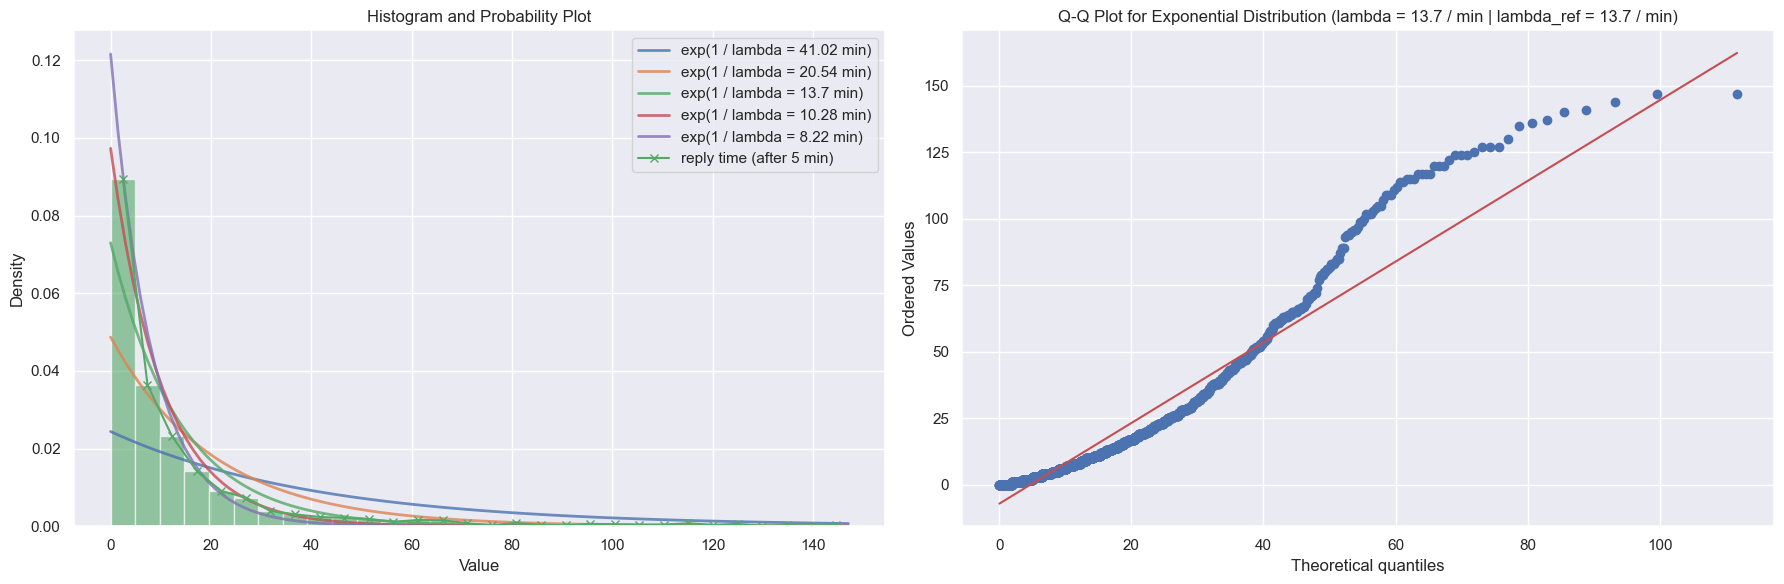

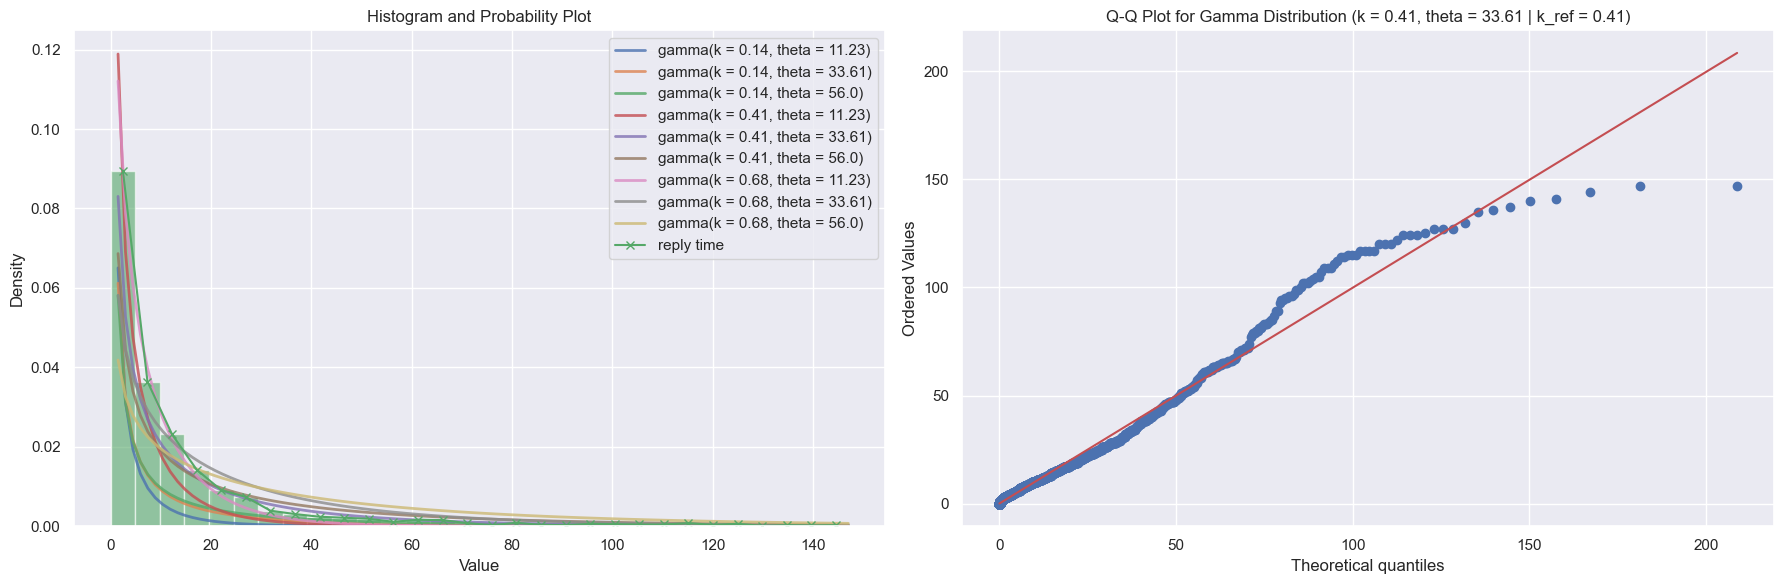

In [363]:
y_min = 5
y_max = 150
cut_memory = True

user_0 = reply[reply['user'] == 'hanna']
user_values = user_0[user_0['minutes'] >= y_min]['minutes']
if cut_memory:
    user_values = user_values[user_0['minutes'] <= y_max + y_min]
    user_values -= y_min
else:
    user_values = user_values[user_0['minutes'] <= y_max]

exponential_comparison_plot(user_values, n_lambda_values=5, lambda_values_range_prct=0.666, histogram='bins')
gamma_comparison_plot(user_values, k_values='auto', n_k_values=3, k_values_range_prct=0.666, k_ref='auto', histogram='bins')

#### User 1

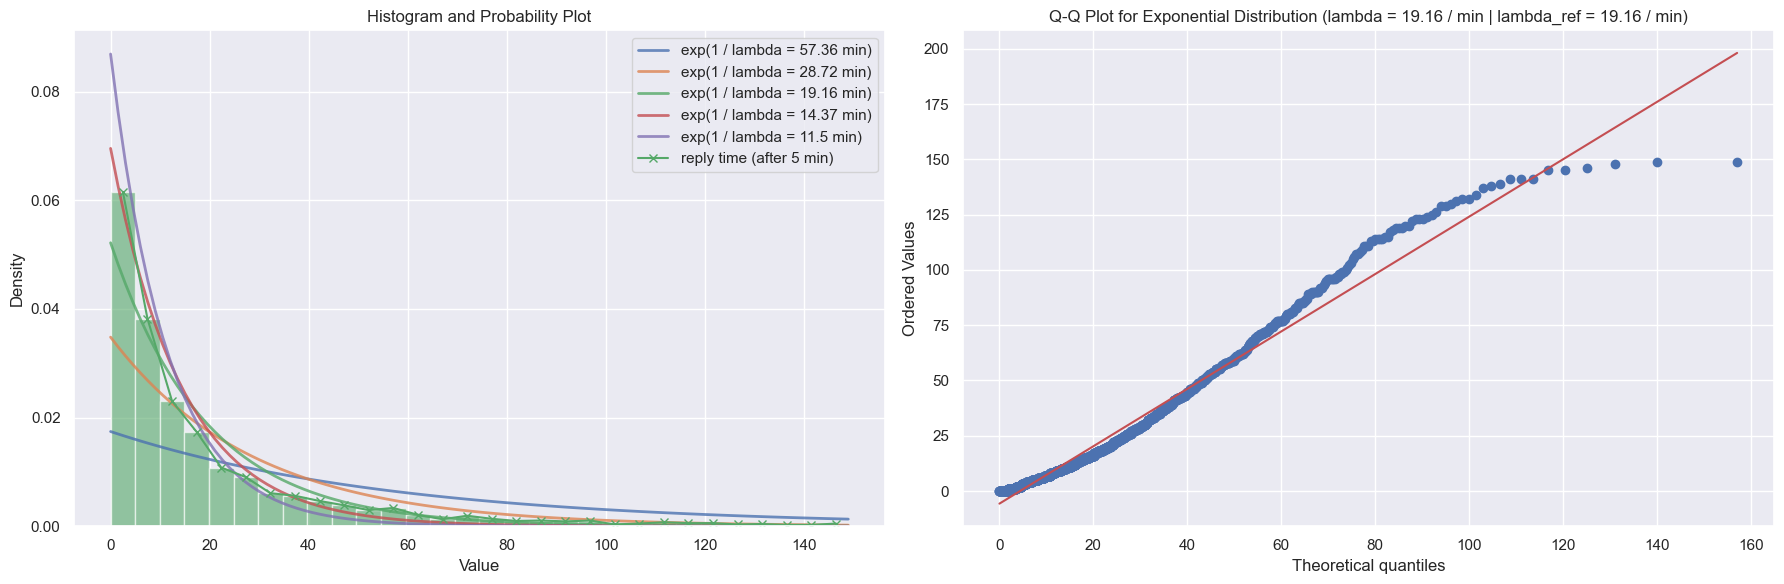

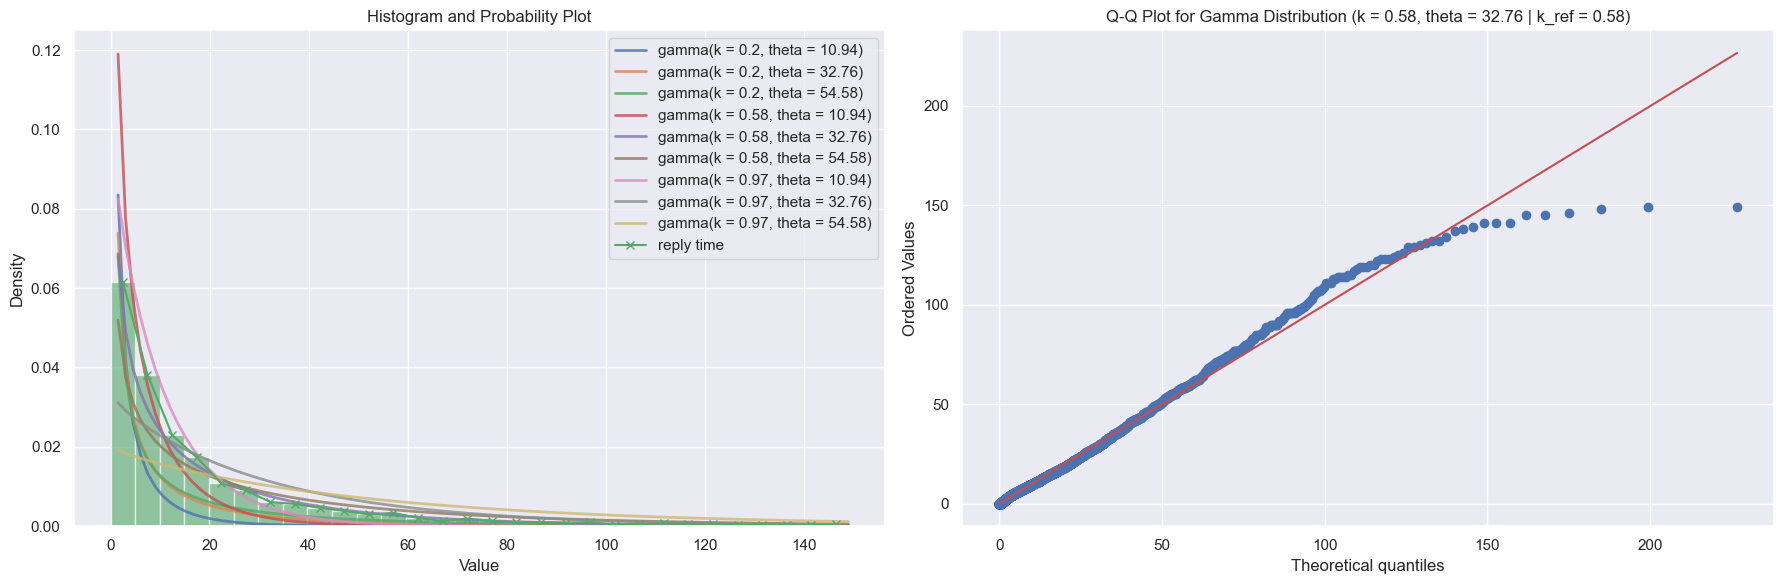

In [376]:
y_min = 5
y_max = 150
cut_memory = True

user_0 = reply[reply['user'] == 'Luis']
user_values = user_0[user_0['minutes'] >= y_min]['minutes']
if cut_memory:
    user_values = user_values[user_0['minutes'] <= y_max + y_min]
    user_values -= y_min
else:
    user_values = user_values[user_0['minutes'] <= y_max]

exponential_comparison_plot(user_values, n_lambda_values=5, lambda_values_range_prct=0.666, histogram='bins')
gamma_comparison_plot(user_values, k_values='auto', n_k_values=3, k_values_range_prct=0.666, k_ref='auto', histogram='bins')

## Time between first and last messages of a reply

#### User 0

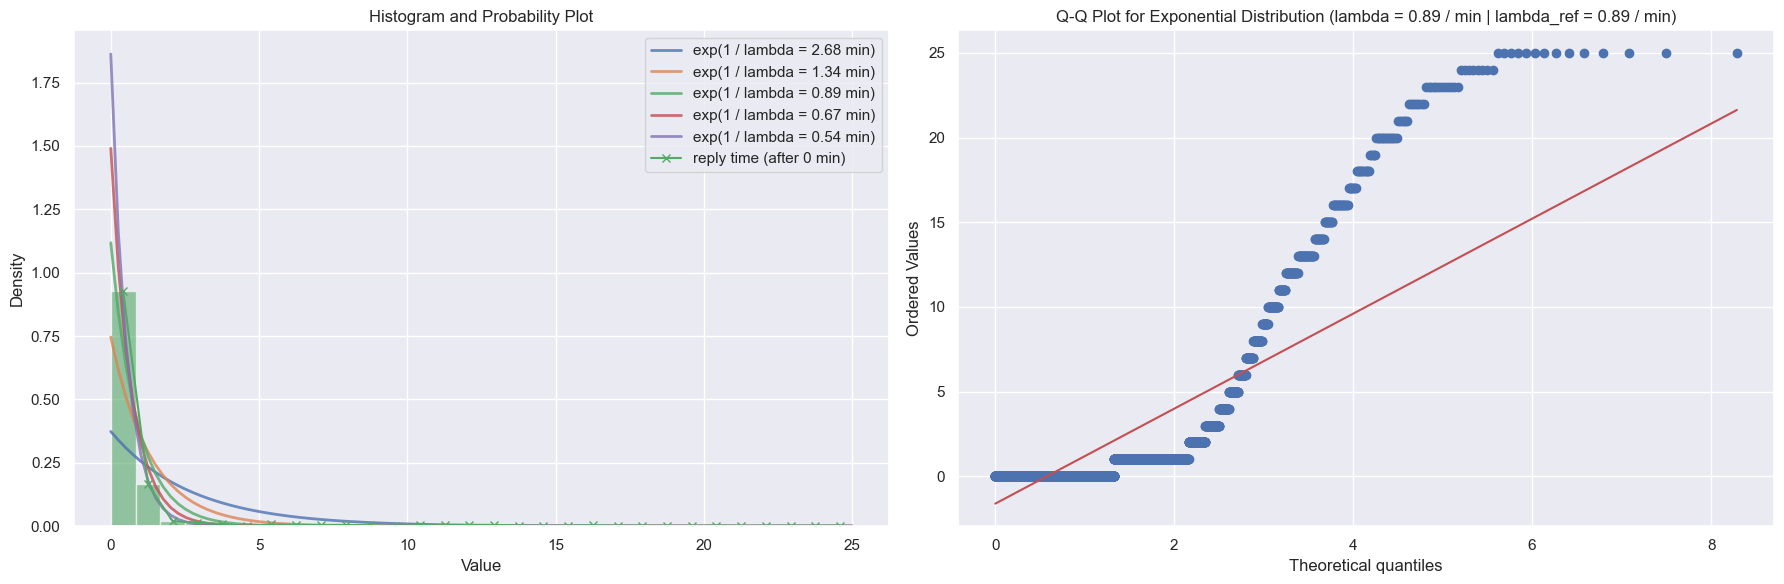

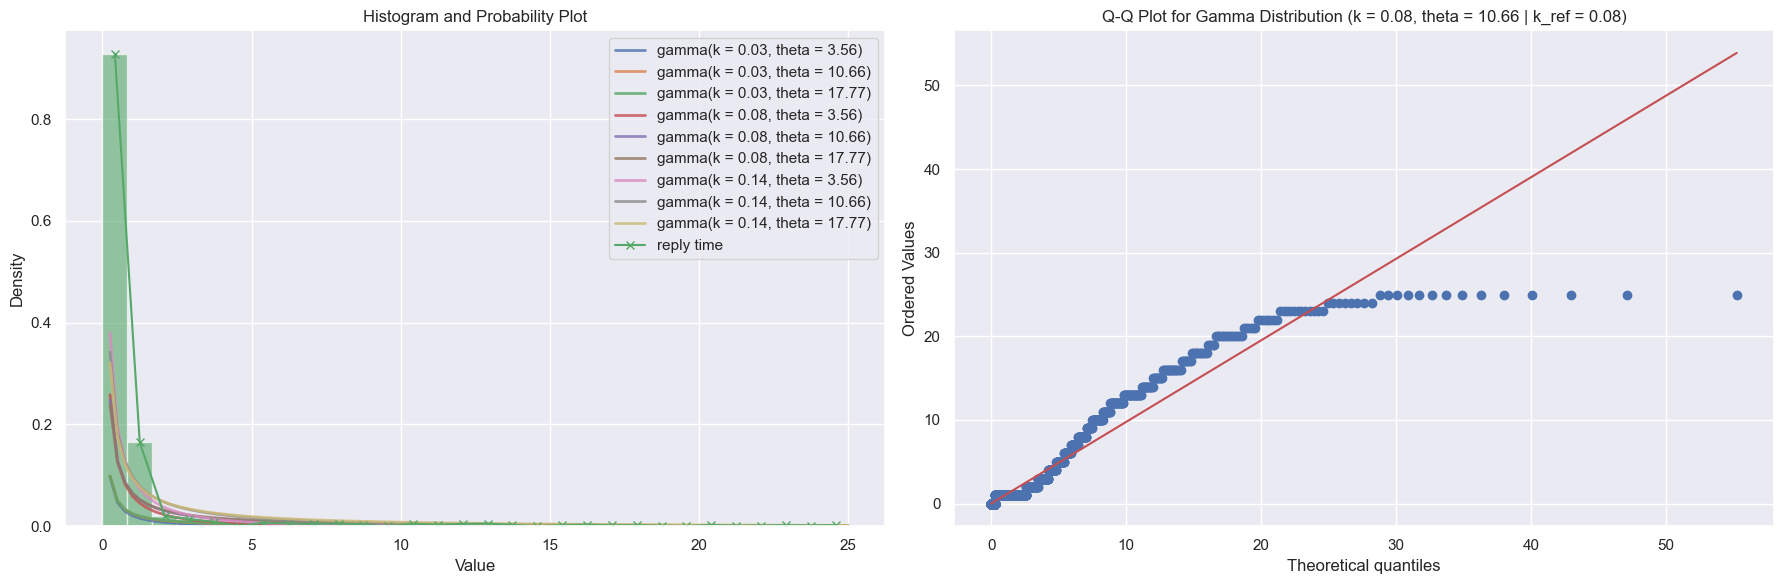

In [392]:
import numpy as np

y_min = 0
y_max = 25
user_replying = replying[replying['user'] == 'hanna']
user_replying_cut = user_replying[(user_replying['minutes'] >= y_min) & (user_replying['minutes'] <= y_max)]

# Generate exponentially distributed values
values = user_replying_cut['minutes'].values
lambda_param = 1 / np.mean(values)

exponential_comparison_plot(values, n_lambda_values=5, lambda_values_range_prct=0.666, histogram='bins')
gamma_comparison_plot(values, k_values='auto', n_k_values=3, k_values_range_prct=0.666, k_ref='auto', histogram='bins')

#### User 1

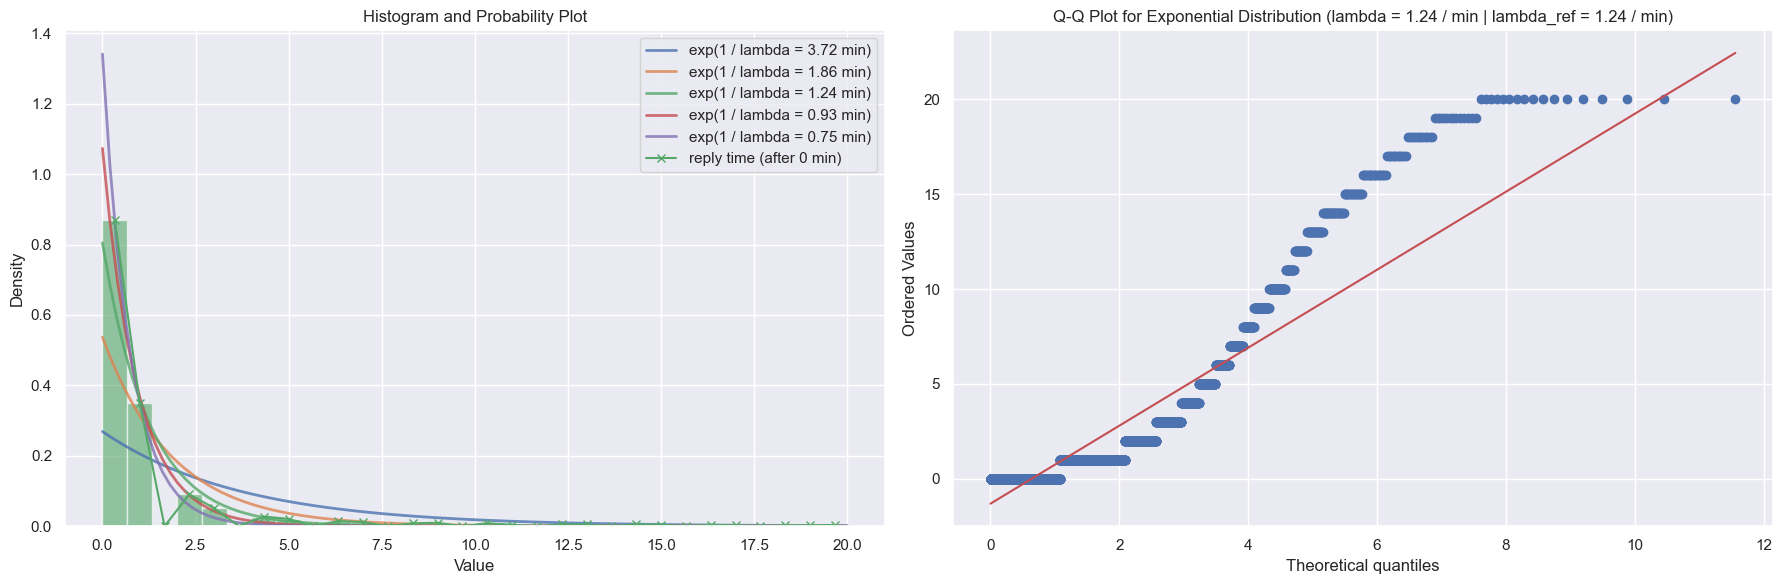

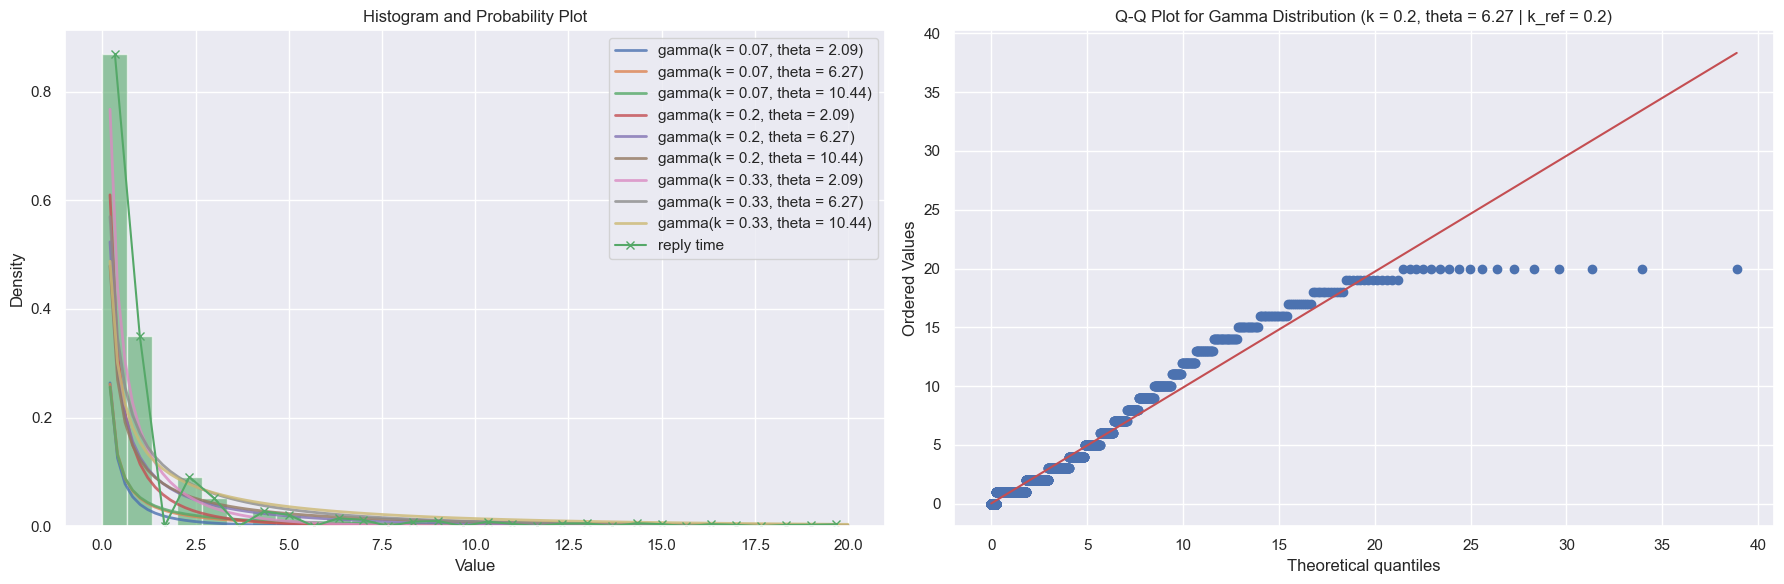

In [393]:
import numpy as np

y_min = 0
y_max = 20
user_replying = replying[replying['user'] == 'Luis']
user_replying_cut = user_replying[(user_replying['minutes'] >= y_min) & (user_replying['minutes'] <= y_max)]

# Generate exponentially distributed values
values = user_replying_cut['minutes'].values
lambda_param = 1 / np.mean(values)

exponential_comparison_plot(values, n_lambda_values=5, lambda_values_range_prct=0.666, histogram='bins')
gamma_comparison_plot(values, k_values='auto', n_k_values=3, k_values_range_prct=0.666, k_ref='auto', histogram='bins')

## Time between first and last messages of a conversation

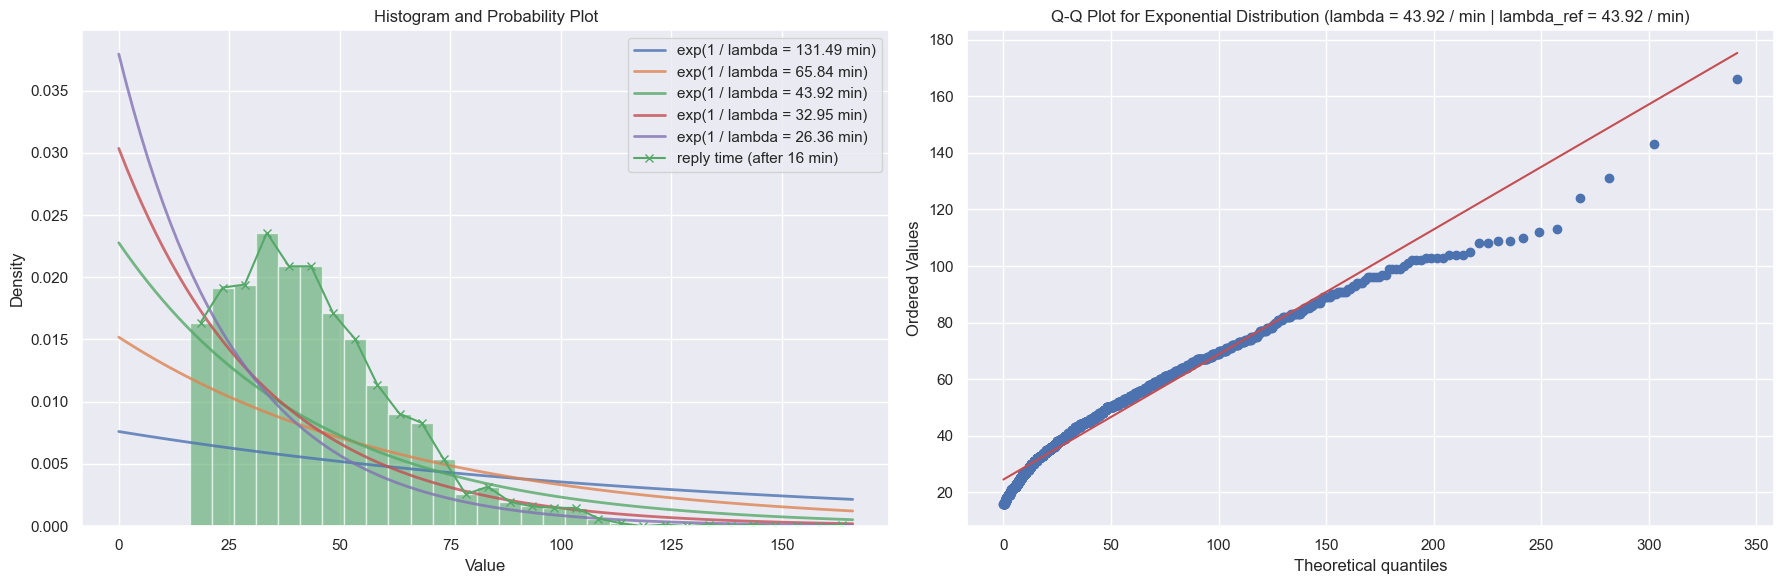

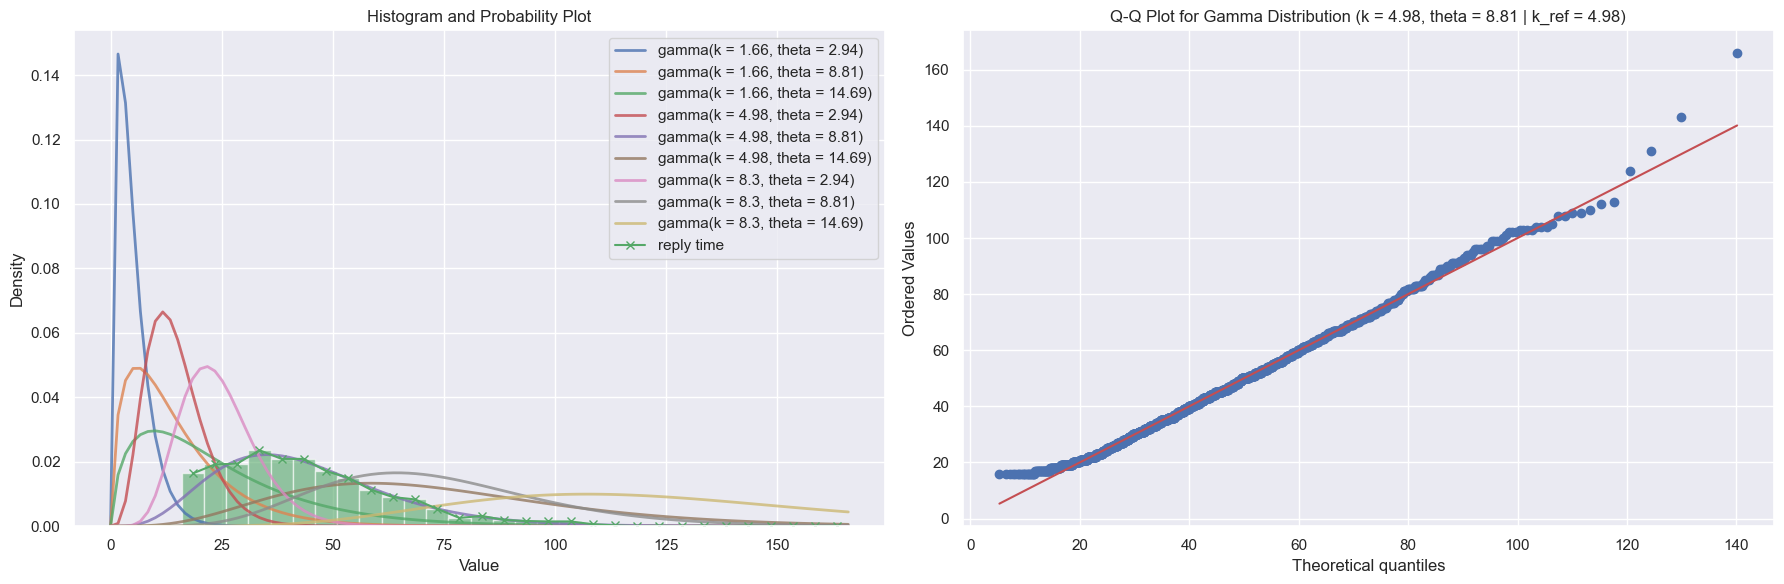

In [390]:
import numpy as np

y_min = 16
y_max = 300

# Generate exponentially distributed values
non_outliers = df['label'].value_counts()[df['label'].value_counts() >= 0].index
data_values = talks[talks.isin(non_outliers)]
data_values = data_values[(data_values['minutes'] <= y_max) & (data_values['minutes'] >= y_min)]

values = data_values['minutes'].values
lambda_param = 1 / np.mean(values)

exponential_comparison_plot(values, n_lambda_values=5, lambda_values_range_prct=0.666, histogram='bins')
gamma_comparison_plot(values, k_values='auto', n_k_values=3, k_values_range_prct=0.666, k_ref='auto', histogram='bins')

## Time between conversations

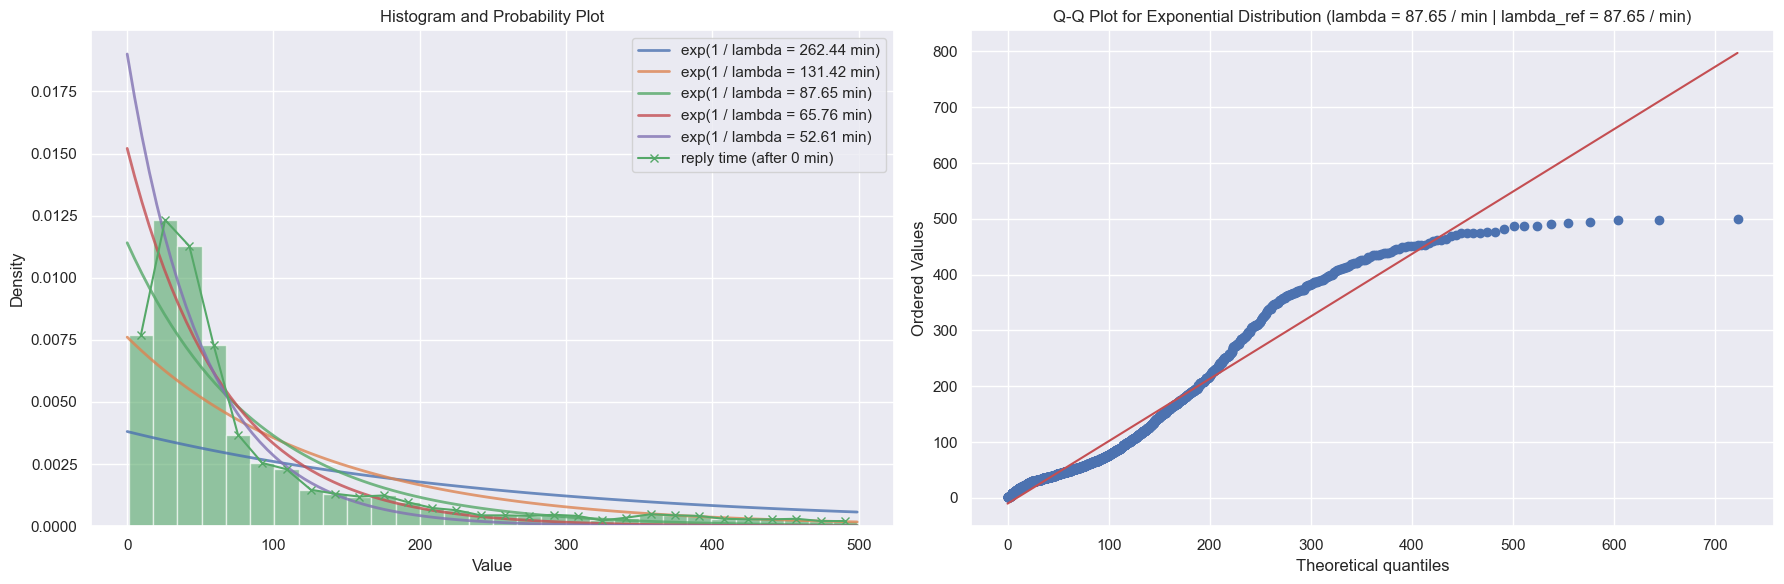

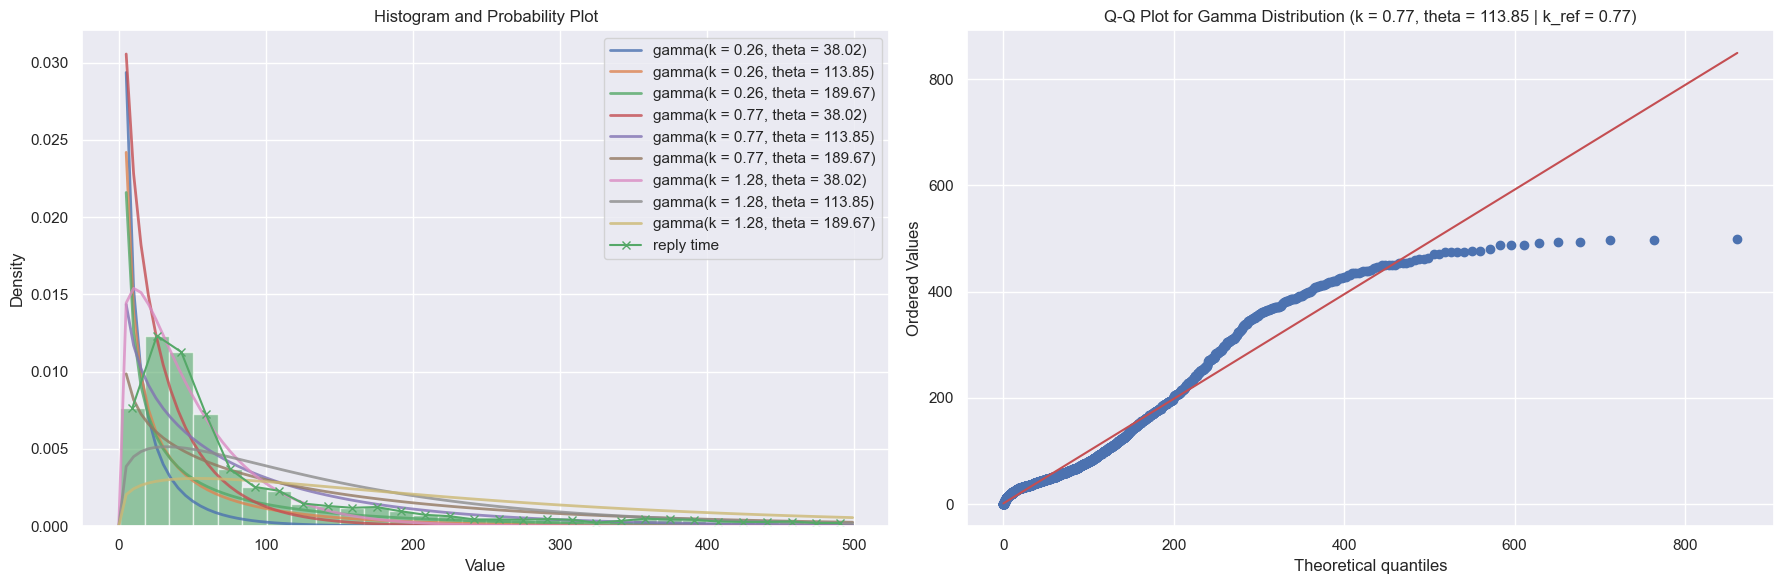

In [391]:
import numpy as np

y_min = 0
y_max = 500

# Generate exponentially distributed values
non_outliers = df['label'].value_counts()[df['label'].value_counts() >= 0].index
data_values = talks[talks.isin(non_outliers)]
data_values = data_values[data_values['minutes_inter'] <= y_max]

values = data_values['minutes_inter'].values
lambda_param = 1 / np.mean(values)

exponential_comparison_plot(values, n_lambda_values=5, lambda_values_range_prct=0.666, histogram='bins')
gamma_comparison_plot(values, k_values='auto', n_k_values=3, k_values_range_prct=0.666, k_ref='auto', histogram='bins')

---
# Extra: Clusters of messages (interactive)

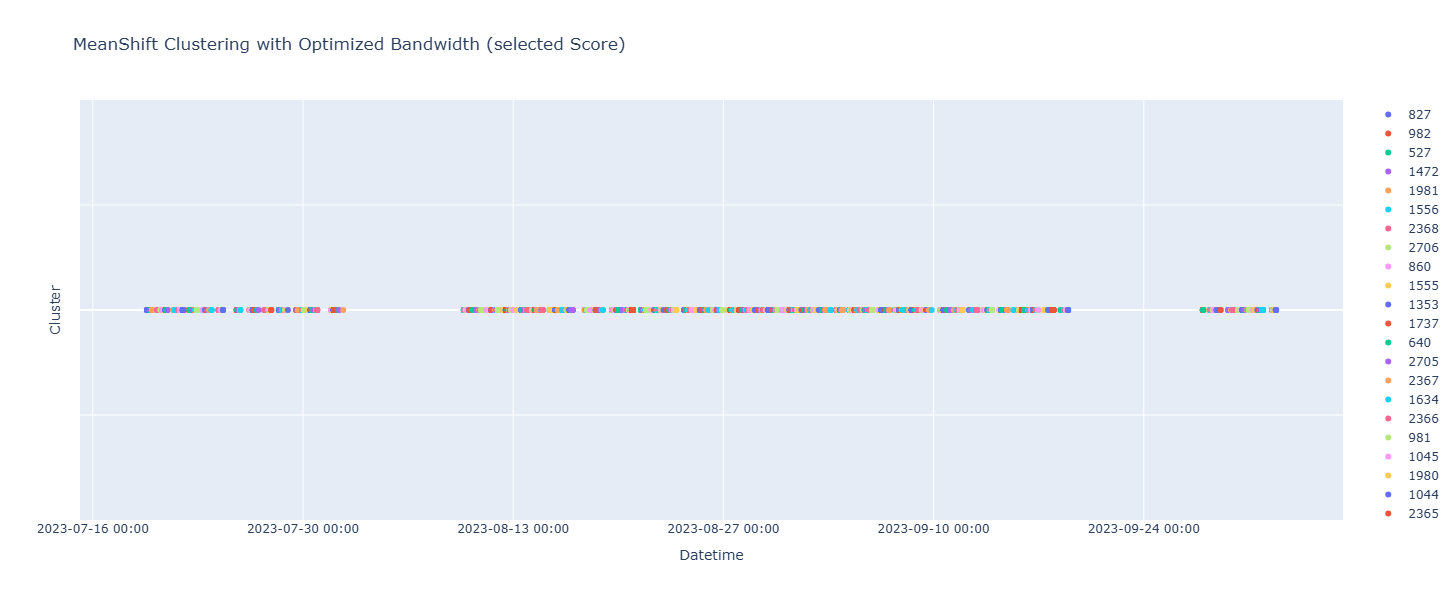

In [394]:
# !pip install plotly

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

i_max = 10000

labels = df['label'].iloc[:i_max]
unique_labels = df['label'].iloc[:i_max].unique()

colors = [px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] for i in range(len(unique_labels))]

fig = go.Figure()

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = df.iloc[:i_max][class_member_mask]['uuid']
    noise = (df.iloc[:i_max]['user'][class_member_mask] == 'Luis').astype(int).values
    y = [0] * len(xy)
    # y = noise
    fig.add_trace(go.Scatter(
        x=as_datetime(xy),
        y=y,
        mode='markers',
        marker=dict(color=col),
        name=str(k)
    ))

fig.update_layout(
    title='MeanShift Clustering with Optimized Bandwidth (selected Score)',
    xaxis_title='Datetime',
    yaxis_title='Cluster',
    yaxis=dict(showticklabels=False),  # Hide y-axis labels since they are all 0
    xaxis=dict(tickformat='%Y-%m-%d %H:%M'),
    showlegend=True,
    height=600,
    width=1000,
)

fig.show()


---
# Extra: Test exponential distribution

## Testing exponential distribution for set of values

In [194]:
from scipy.stats import kstest, expon

# values = user_values
values = pd.Series(user_values).sample(100)

# Perform the K-S test
D, p_value = kstest(values, 'expon', args=(0, 1/lambda_param))
print(f"K-S Test Statistic: {D}")
print(f"P-value: {p_value}")


K-S Test Statistic: 0.7768698398515702
P-value: 3.3287736319878196e-64


In [195]:
from scipy.stats import anderson

# Perform the Anderson-Darling test
result = anderson(values, dist='expon')
print(f"Anderson-Darling Test Statistic: {result.statistic}")
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    print(f"Significance level: {sl:.2f}, Critical value: {cv:.3f}")
    if result.statistic < cv:
        print("The data follows the exponential distribution for this significance level.")
    else:
        print("The data does not follow the exponential distribution for this significance level.")


Anderson-Darling Test Statistic: 3.789593697091348
Significance level: 15.00, Critical value: 0.917
The data does not follow the exponential distribution for this significance level.
Significance level: 10.00, Critical value: 1.072
The data does not follow the exponential distribution for this significance level.
Significance level: 5.00, Critical value: 1.333
The data does not follow the exponential distribution for this significance level.
Significance level: 2.50, Critical value: 1.596
The data does not follow the exponential distribution for this significance level.
Significance level: 1.00, Critical value: 1.945
The data does not follow the exponential distribution for this significance level.


In [196]:
from scipy.stats import chisquare

# Number of bins
num_bins = 30

# Observed frequencies
observed_freq, bins = np.histogram(values, bins=num_bins)

# Expected frequencies
expected_freq = len(values) * (expon.cdf(bins[1:], scale=1/lambda_param) - expon.cdf(bins[:-1], scale=1/lambda_param))

# Adjust expected frequencies to match the sum of observed frequencies
expected_freq *= observed_freq.sum() / expected_freq.sum()

# Perform the Chi-Square test
chi2_stat, p_val = chisquare(observed_freq, f_exp=expected_freq)
print(f"Chi-Square Test Statistic: {chi2_stat}")
print(f"P-value: {p_val}")


Chi-Square Test Statistic: 248452801.493633
P-value: 0.0


In [197]:
import numpy as np

# Generate exponentially distributed values
# np.random.seed(42)
# lambda_param = 1.5
# values = np.random.exponential(1/lambda_param, 1000)

# Perform MLE for the rate parameter lambda
sample_mean = np.mean(values)
mle_lambda = 1 / sample_mean

print(f"Sample Mean: {sample_mean}")
print(f"MLE for lambda: {mle_lambda}")


Sample Mean: 3.93
MLE for lambda: 0.2544529262086514
